# Data loading

<a href="https://colab.research.google.com/github/FuturisticLover123/InnowiseInternship/blob/main/task1/dqc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import boto3
from dotenv import load_dotenv
import io 
import pandas as pd

load_dotenv()

YC_ACCESS_KEY_ID = os.getenv("YC_ACCESS_KEY_ID")
YC_SECRET_ACCESS_KEY = os.getenv("YC_SECRET_ACCESS_KEY")
YC_ENDPOINT_URL = os.getenv("YC_ENDPOINT_URL")
YC_BUCKET_NAME = os.getenv("YC_BUCKET_NAME")

In [4]:
session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=YC_ENDPOINT_URL,
    aws_access_key_id=YC_ACCESS_KEY_ID,
    aws_secret_access_key=YC_SECRET_ACCESS_KEY
)

In [5]:
import gzip

file_names = ["item_categories.csv.gzip", "items.csv.gzip", "sample_submission.csv.gzip", "shops.csv.gzip", "test.csv.gzip", "sales_train.csv.gzip"]
data_location = "compressed_data/"

data_storage = dict()
for file_name in file_names:
    response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'{data_location}{file_name}')
    data_storage[file_name[: len(file_name) - 9]] = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')


train = data_storage["sales_train"]

# Data Quality Check

Importing nessesary modules

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [7]:
missing_items = set(train['item_id']).union(set(data_storage["test"]['item_id'])) - set(data_storage["items"]['item_id'])
print(len(missing_items))

missing_shops = set(train['shop_id']).union(set(data_storage["test"]['shop_id'])) - set(data_storage["shops"]['shop_id'])
print(len(missing_shops))


0
0


All data points have a valid reference to a shop and a category. This is a positive characteristic as it ensures the integrity of the dataset.

In [8]:
print(train.isna().sum().sum(), data_storage["shops"].isna().sum().sum(), data_storage["items"].isna().sum().sum(), data_storage["item_categories"].isna().sum().sum(), data_storage["test"].isna().sum().sum())


0 0 0 0 0


All data points are complete with no missing values. There's no need for data imputation, which can be a complex and error-prone process.

# Returns treory

In [9]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Analysis of Returns
This code analyzes a sales dataset to prove that negative transaction quantities are actually product returns, not data errors.

It works by splitting the data into two groups: sales (positive quantity) and returns (negative quantity). The key step is to find a matching "sale" for each "return." A match is defined by:

    The shop_id, item_id, and item_price are identical.

    The sale date is earlier than the return date.

    The absolute value of the return quantity equals the sale quantity.

By counting how many returns successfully find a matching sale, the code calculates the percentage of negative transactions that follow this logical return pattern. A high match percentage suggests the negative values are indeed legitimate returns, providing strong evidence against the data anomaly hypothesis.

In [10]:
import pandas as pd


returns_df = train[train['item_cnt_day'] < 0].copy()


sales_df = train[train['item_cnt_day'] > 0].copy()

returns_df['item_cnt_day_abs'] = returns_df['item_cnt_day'].abs()
returns_df = returns_df[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day_abs']].rename(
    columns={'date': 'date_return', 'date_block_num': 'date_block_num_return', 'item_cnt_day_abs': 'item_cnt_day_return'}
)

sales_df = sales_df[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']].rename(
    columns={'date': 'date_sale', 'date_block_num': 'date_block_num_sale', 'item_cnt_day': 'item_cnt_day_sale'}
)

matched_transactions = pd.merge(
    returns_df,
    sales_df,
    on=['shop_id', 'item_id', 'item_price'],
    how='left'
)

matched_transactions = matched_transactions[
    (matched_transactions['date_block_num_sale'] < matched_transactions['date_block_num_return']) &
    (matched_transactions['item_cnt_day_sale'] == matched_transactions['item_cnt_day_return'])
]

matched_returns = matched_transactions.drop_duplicates(subset=['date_return', 'shop_id', 'item_id'])


total_returns = len(returns_df)
found_matches = len(matched_returns)
match_percentage = (found_matches / total_returns) * 100

print(f"Total return transactions: {total_returns}")
print(f"Number of returns with a matching sale found: {found_matches}")
print(f"Percentage of returns with a match found: {match_percentage:.2f}%")

Total return transactions: 7356
Number of returns with a matching sale found: 4988
Percentage of returns with a match found: 67.81%


Overview of Results: Transaction Match Percentage

Our analysis revealed that 67.81% of transactions with a negative quantity (item_cnt_day) have a corresponding positive sale.

 These pairs matched on store, item,
 price, and quantity, with the sale occurring before the return.

In [11]:
sales = train[train['item_cnt_day'] > 0].copy()
returns = train[train['item_cnt_day'] < 0].copy()

### Data Aggregation Strategy for Time Series Forecasting

The `item_cnt_day` variable is highly volatile. By summing daily sales to a monthly level, we reduce noise and leverage the **Central Limit Theorem** for a more stable, predictable distribution.

This approach is crucial as it aligns our feature engineering with the **monthly target variable** of the competition, making our model more effective for forecasting.

<Axes: xlabel='item_price', ylabel='Density'>

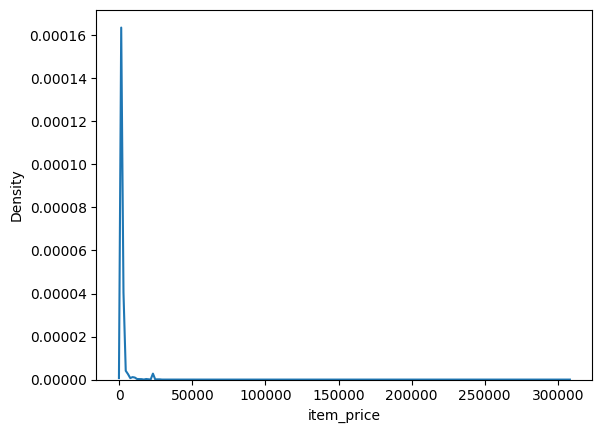

In [12]:
sns.kdeplot(train['item_price'])

### Analysis of Item Price Distribution

The plot of item prices appears to show an **exponential decay** pattern, where most transactions occur at lower price points and a small number of items are sold at very high prices.

This suggests the presence of **anomalies** associated with these extremely high-priced items. These outliers may skew our data analysis and require further cleaning before model training.

In [13]:
data_storage['items']

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [14]:
train[train['item_price'] > 40000].merge(data_storage['items'], on='item_id', how='left')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,17.09.2013,8,12,11365,59200.0,1.0,Доставка (EMS),9
1,24.10.2013,9,12,7238,42000.0,1.0,UserGate Proxy & Firewall 6.X до 100 сессий,75
2,13.12.2013,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75
3,20.03.2014,14,25,13199,50999.0,1.0,Коллекционные шахматы (Властелин Колец),69
4,20.11.2014,22,12,14173,40900.0,1.0,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,75
5,29.01.2015,24,12,7241,49782.0,1.0,UserGate Proxy & Firewall 6.X с модулем фильтр...,75
6,23.10.2015,33,42,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
7,20.10.2015,33,38,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
8,20.10.2015,33,12,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
9,29.10.2015,33,12,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16


### Analysis of Potential Anomalies in High-Value Transactions

Upon reviewing the most expensive items in the dataset, several transactions are highly questionable and likely represent data anomalies.

* **Logistical Services:** A delivery service (EMS) priced at 60,000 units is highly improbable and should be considered a data entry error.
* **High-End Goods:** A transaction for chess at 50,000 units appears anomalous, as this price point suggests an item of extraordinary value, such as a luxury or custom-made set. Without such a description, the price is suspicious.
* **Software Licensing:** A price of 300,000 units for "Radmin 3" is a significant outlier. This value is inconsistent with common software pricing and suggests a clear data anomaly.

Conversely, other high-value transactions for items like expensive electronics or other premium goods appear plausible and are likely accurate reflections of real-world pricing. Further investigation of these specific entries is recommended to confirm their status before proceeding with model training.

# Shops

Some duplicates found in "shops"

    !Якутск Орджоникидзе, 56 фран
    !Якутск ТЦ "Центральный" фран
    Жуковский ул. Чкалова 39м
    РостовНаДону ТРК "Мегацентр Горизонт" Островной	

Fixing it

In [15]:
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
data_storage['test'].loc[data_storage['test'].shop_id == 0, 'shop_id'] = 57


sales.loc[sales.shop_id == 1, 'shop_id'] = 58
data_storage['test'].loc[data_storage['test'].shop_id == 1, 'shop_id'] = 58

sales.loc[sales.shop_id == 10, 'shop_id'] = 11
data_storage['test'].loc[data_storage['test'].shop_id == 10, 'shop_id'] = 11

sales.loc[sales.shop_id == 39, 'shop_id'] = 40
data_storage['test'].loc[data_storage['test'].shop_id == 39, 'shop_id'] = 40

Adding categirical features shop_city and  shop_type to shops

In [16]:
data_storage["shops"]['shop_city'] = data_storage["shops"]['shop_name'].apply(lambda x: x.split()[0])
data_storage["shops"]['shop_type'] = data_storage["shops"]['shop_name'].apply(lambda x: x.split()[1])

replacing unknown catigories with "other"

In [17]:
values_to_keep =['ТЦ', 'ТРК', 'ТРЦ', 'Торговля', 'ЧС', '"Распродажа"', 'МТРЦ', 'Магазин', 'ТК','склад']

data_storage["shops"].loc[~data_storage["shops"]['shop_type'].isin(values_to_keep), 'shop_type'] = 'other'

In [18]:
data_storage["shops"]['shop_type'].unique()

array(['other', 'ТЦ', 'ТРК', 'ТРЦ', 'Торговля', 'ЧС', '"Распродажа"',
       'МТРЦ', 'Магазин', 'ТК', 'склад'], dtype=object)

# item categories

Adding categiries to items

In [19]:
data_storage["item_categories"]['split'] = data_storage["item_categories"]['item_category_name'].str.split('-')
data_storage["item_categories"]['item_category_type'] = data_storage["item_categories"]['split'].map(lambda x: x[0].strip())
data_storage["item_categories"]['item_category_subtype'] = data_storage["item_categories"]['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
data_storage["item_categories"].drop('split', axis = 1, inplace = True)


In [20]:
data_storage["item_categories"].head()

,item_category_name,item_category_id,item_category_type,item_category_subtype
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [21]:
data_storage.keys()

dict_keys(['item_categories', 'items', 'sample_submission', 'shops', 'test', 'sales_train'])

In [22]:
data_storage["items"]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


# Uploading data to S3

In [23]:
directory = "filtered_data/"


for key, df in data_storage.items():
    buffer = io.BytesIO()
    df.to_csv(buffer, index=False, compression='gzip')
    buffer.seek(0)
    s3_client.upload_fileobj(buffer, YC_BUCKET_NAME, f"{directory}{key}.csv.gzip")

